In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import warnings
import networkx

warnings.filterwarnings('ignore')

import re
import os

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#from data_preprocesser import preprocessed_data_path, create_file, split_raw_csv_review_file

from textblob import TextBlob
verbs = ['VB','VBD','VBG','VBN','VBP','VBZ']
others = ['RBR','RBS','UH','FW','JJ','JJR','JJS']
tags = ['NN','NNS','NNP','NNPS']

raw_data_path = './data_yelp/raw/'
preprocessed_data_path = './data_yelp/preprocessed/'
reviews_type_path = 'categories_30000/yelp_academic_dataset_review_Auto Repair.csv'

# Processing functions

In [53]:
# Separer en phrases avec ponctuation




def identify_tokens(row):
    sentences = row['sentences']
    token_words = []
    for sentence in sentences :
        tokens = nltk.word_tokenize(sentence)
        # taken only words (not punctuation)
        # token_words = [re.sub("[^\w\s]", " ", w) for w in tokens]
        token_words.append([w for w in tokens if w.isalpha()])
    return token_words


def split_to_sentences(row):
    review = row['text']
    delimiters = ['?','!','.',',',';',':','\n','"','(',')']
    regexPattern = '|'.join(map(re.escape, delimiters))
    sentences = re.split(regexPattern,review)
    sentences = [sentence for sentence in sentences if sentence and sentence != ' ']
    return sentences

### Garder juste les noms, verbes, adjectifs et interjections

def select_tagged(row):
    sentences = row['sentences']
    useful_words = []
    for sentence in sentences :
        list_words = sentence.split(' ')
        list_words = [w for w in list_words if w]
        tagged_words = nltk.pos_tag(list_words)
        useful_words.append([w[0] for w in tagged_words if w[1] in tags and w[0] != 'i' and w[0] != 'u'])
    return useful_words

stop_words = stopwords.words('english')
stops_empiric = ['i','u',"it's","don't","they're",'wa',"didn't",'was','done','were','went','had','got','has','am',"i'm","i've"]
stops_empiric.extend(stop_words)



def remove_stops(row):
    sentences = row['words_useful']
    useful_words = []

    for sentence in sentences :
        new_sentence = []
        for w in sentence :
            if w not in stops_empiric :
                new_sentence.append(w)
        useful_words.append(new_sentence)
    return useful_words

### Enlever les mots trops polarisés

def unpolarized(row):
    sentences = row['words_lemmatized']
    unpolarized_words = []
    for sentence in sentences :
        unpolarized_words.append([w for w in sentence if (abs(TextBlob(w).sentiment.polarity)<0.2 
            and abs(TextBlob(w).sentiment.polarity<0.2))])
    return unpolarized_words

stemming = PorterStemmer()

def stem_list(row):
    sentences = row['words_meaningful']
    stemmed_sentences = []
    for sentence in sentences :
        stemmed_sentences.append([stemming.stem(word) for word in sentence])
    return (stemmed_sentences)

lemming = WordNetLemmatizer()

def lem_list(row):
    sentences = row['words_useful']
    lemmed_sentences = []
    for sentence in sentences :
        lemmed_sentences.append([lemming.lemmatize(word) for word in sentence])
    return (lemmed_sentences)

def rejoin_words(row):
    sentences = row['words_meaningful']
    joined_words = []
    for sentence in sentences :
        joined_words.extend(sentence)
    return joined_words

def index_words(row):
    sentences = row['words_useful']
    all_words = row['words']
    indexes = []
    for j,sentence in enumerate(sentences) :
        indexes.append([(w,all_words[j].index(w)) for w in sentence])
    return indexes

In [39]:
lemming = WordNetLemmatizer()
print(lemming.lemmatize("restaurants"))

restaurant


In [56]:
def process(data_df):
    data_df['text'] = data_df['text'].str.lower()
    print(1)
    data_df['sentences'] = data_df.apply(split_to_sentences,axis=1)
    print(2)
    data_df['words'] = data_df.apply(identify_tokens,axis=1)
    print(3)
    data_df['words_useful'] = data_df.apply(select_tagged,axis=1)
    print(4)
    data_df['words_useful'] = data_df.apply(remove_stops,axis=1)
    print(5)
    data_df['words_lemmatized'] = data_df.apply(lem_list, axis=1)
    print(6)
    data_df['words_meaningful'] = data_df.apply(unpolarized, axis=1)
    print(7)
    #data_df['index_meaningful'] = data_df.apply(index_words,axis=1)
    #print(8)
    data_df['joined_words'] = data_df.apply(rejoin_words,axis=1)

    return data_df

In [58]:
df = pd.read_csv('data_yelp/preprocessed/categories_30000/yelp_academic_dataset_review_Restaurants.csv')
processed_df = process(df)
processed_df.head(5)

1
2
3
4
5
6
7


,review_id,business_id,stars_x,stars_y,date,city,text,categories,sentences,words,words_useful,words_lemmatized,words_meaningful,joined_words
0,vkVSCC7xljjrAI4UGfnKEQ,AEx2SYEUJmTxVVB18LlCwA,5,4.0,2016-05-28,Montréal,super simple place but amazing nonetheless. it...,Diners;Food;Restaurants;Delis,"[super simple place but amazing nonetheless, ...","[[super, simple, place, but, amazing, nonethel...","[[place, nonetheless], [thing], [bologna, sala...","[[place, nonetheless], [thing], [bologna, sala...","[[place, nonetheless], [thing], [bologna, sala...","[place, nonetheless, thing, bologna, salami, s..."
1,n6QzIUObkYshz4dz2QRJTw,VR6GpWIda3SfvPC-lg9H3w,5,4.5,2016-05-28,Montréal,small unassuming place that changes their menu...,Restaurants;Canadian (New);Italian,[small unassuming place that changes their men...,"[[small, unassuming, place, that, changes, the...","[[place, menu], [decor, vibe, seat, restaurant...","[[place, menu], [decor, vibe, seat, restaurant...","[[place, menu], [decor, vibe, seat, restaurant...","[place, menu, decor, vibe, seat, restaurant, c..."
2,MV3CcKScW05u5LVfF6ok0g,CKC0-MOWMqoeWf6s-szl8g,5,4.0,2016-05-28,Outremont,lester's is located in a beautiful neighborhoo...,Specialty Food;Food;Sandwiches;Restaurants;Bur...,[lester's is located in a beautiful neighborho...,"[[lester, is, located, in, a, beautiful, neigh...","[[lester's, neighborhood], [meat, deli's, bris...","[[lester's, neighborhood], [meat, deli's, bris...","[[lester's, neighborhood], [meat, deli's, bris...","[lester's, neighborhood, meat, deli's, brisket..."
3,IXvOzsEMYtiJI0CARmj77Q,ACFtxLv8pGrrxMm6EgjreA,4,3.5,2016-05-28,Montréal,love coming here. yes the place always needs t...,Fast Food;Restaurants;Burgers,"[love coming here, yes the place always needs...","[[love, coming, here], [yes, the, place, alway...","[[love], [place, floor, peanuts, shell, bit], ...","[[love], [place, floor, peanut, shell, bit], [...","[[], [place, floor, peanut, shell, bit], [food...","[place, floor, peanut, shell, bit, food, speak..."
4,L_9BTb55X0GDtThi6GlZ6w,s2I_Ni76bjJNK9yG60iD-Q,4,4.5,2016-05-28,Montréal,had their chocolate almond croissant and it wa...,Bakeries;Restaurants;Food;Sandwiches;Cafes;Cof...,[had their chocolate almond croissant and it w...,"[[had, their, chocolate, almond, croissant, an...","[[chocolate, almond, croissant], [buttery, cho...","[[chocolate, almond, croissant], [buttery, cho...","[[chocolate, almond, croissant], [buttery, cho...","[chocolate, almond, croissant, buttery, chocol..."


### Save as a csv

In [61]:
path = 'data_yelp/preprocessed/yelp_academic_dataset_review_Restaurants.pkl'


processed_df.to_pickle(path)



### Get dataframe

In [62]:
path = 'data_yelp/preprocessed/yelp_academic_dataset_review_Restaurants.pkl'

processed_df = pd.read_pickle(path)


## Build graph

In [127]:
reviews_with_sentences = processed_df['words_lemmatized']

graph = {}
for review in reviews_with_sentences :
    for sentence in review :
        for w1 in sentence :
            if w1 in graph.keys() :
                for w2 in sentence :
                    if w2 in graph[w1].keys() :
                        graph[w1][w2] += 1
                    else :
                        graph[w1][w2] = 1
            else :
                graph[w1] = {}
                for w2 in sentence :
                    graph[w1][w2] = 1
print(graph['vehicle'])
            

        

{'sell': 97, 'wrecked': 5, 'vehicle': 9856, 'purchasing': 198, 'began': 21, 'having': 148, 'make': 218, 'pocket': 8, 'repair': 422, 'suspension': 5, 'trade': 87, 'process': 60, 'found': 138, 'planet': 8, 'nissan': 54, 'had': 1131, 'sold': 91, 'knowing': 27, 'wa': 2364, 'involved': 16, '"major"': 1, 'car': 596, 'accident': 45, 'caused': 10, 'frame': 5, 'damage': 66, 'month': 131, 'selling': 32, 'skip': 1, 'chain': 7, 'bring': 200, "it's": 105, 'little': 45, "you've": 5, 'reached': 5, 'point': 50, "can't": 46, 'justify': 1, 'taking': 190, 'dealership': 417, 'service': 728, 'recommend': 271, 'shop': 311, 'need': 364, 'done': 333, "don't": 175, 'want': 153, 'get': 601, 'scammed': 3, 'have': 1404, 'inventory': 15, 'sale': 174, 'staff': 73, 'bought': 167, 'maximum': 2, 'paid': 54, 'way': 113, 'am': 180, 'major': 33, 'issue': 255, 'drive': 258, 'coming': 70, 'purchase': 400, 'went': 277, 'king': 7, 'azure': 3, "didn't": 180, 'do': 383, 'anything': 96, 'exceeded': 2, 'expectation': 18, 'being'

## Graph with NetworkX

In [34]:
import networkx as nx
reviews_with_sentences = processed_df['words_lemmatized']
all_words = processed_df['joined_words'].tolist()
all_words = [inner for outer in all_words for inner in outer]

def create_graph(n):
    fdist = FreqDist(all_words)
    frequent_words = fdist.most_common(n)
    words = [word[0] for word in frequent_words]
    frequencies = [word[1] for word in frequent_words]
    fdist = FreqDist(all_words)
    G = nx.Graph()
    for i,review in enumerate(reviews_with_sentences) :
        for sentence in review :
            for w1 in sentence :
                if w1 in G.nodes :
                    for w2 in sentence :
                        if w2 in words :
                            if w2 in G.adj[w1] :
                                try :
                                    index = words.index(w1)
                                    G.edges[w1,w2]['weight'] += 1/frequencies[index]
                                except ValueError :
                                    print('Nope')
                            else :
                                if w2 not in G.nodes :
                                    G.add_node(w2)
                                    index = words.index(w2)
                                    weight = 1/frequencies[index]
                                    G.add_weighted_edges_from([(w1,w2,weight)])
                else :
                    if w1 in words :
                        G.add_node(w1)
                        for w2 in sentence :
                            if w2 not in G.nodes and w2 in words:
                                G.add_node(w2)
                                index = words.index(w2)
                                weight = 1/frequencies[index]
                                G.add_weighted_edges_from([(w1,w2,weight)])
    return G
G = create_graph(50)

#plt.subplot(121)
#nx.draw(G, with_labels=True, font_weight='bold')


## Build matrix

In [71]:
import numpy as np
reviews_with_sentences = processed_df['words_lemmatized']
reviews = processed_df["joined_words"]

all_words = processed_df['joined_words'].tolist()



all_words = [inner for outer in all_words for inner in outer]


def get_matrix(n):
    fdist = FreqDist(all_words)
    frequent_words = fdist.most_common(n)
    A = np.zeros((n,n))
    words = [word[0] for word in frequent_words]
    frequencies = [word[1] for word in frequent_words]
    for i,review in enumerate(reviews_with_sentences) :
        for sentence in review :
            for w1 in sentence :
                if w1 in words :
                    index1 = words.index(w1)
                    for w2 in sentence :
                        if w2 in words :
                            index2 = words.index(w2)
                            A[index1,index2] += 1
    for i in range(len(A)) :
        A[i][i] = 1
    return(A,words)
        
    
A,words = get_matrix(50)
s = 0

for i in range(len(A)):
    Si = 0
    for j in range(len(A)):
        if A[i][j] > 0 :
            Si += 1
    s += Si
    
print(s/len(A))




49.68


In [21]:
print(np.mean(A))

20.9428


In [66]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_classe(i,classes):
    for c in classes:
        if i in c:
            return(c)

def louvain_1(critere, a, classes):
    n = np.shape(a)[0]
    dico_fusion = {}
    for i in range(n):
        classe_i = get_classe(i,classes)
        moins_classe_i = np.sum([critere(i,j,a) for j in classe_i])
        delta = 0
        classe_found = None
        for classe in classes:
            plus_classe = np.sum([critere(i,j,a) for j in classe])
            if i not in classe:
                plus_classe += critere(i,i,a)
            current_delta = -moins_classe_i+plus_classe
            if current_delta>delta:
                delta = current_delta
                classe_found = classe
        if classe_found:
            classe_found.update({i})
            classe_i.remove(i)
    return([s for s in classes if s])

def merge(classes, a):
    n = len(classes)
    new_a = np.zeros((n,n))
    new_i = 0
    dico = {}
    for classe in classes:
        for i in classe:
            dico[i] = new_i
        new_i+=1
    for i in range(np.shape(a)[0]):
        for j in range(np.shape(a)[1]):
            new_a[dico[i]][dico[j]] = new_a[dico[i]][dico[j]] + a[i][j]
    return(new_a)

def louvain(critere, a, classes_finales={}):
    n = np.shape(a)[0]
    classes = [{i} for i in range(n)]
    if not classes_finales:
        classes_finales = classes.copy()
    classes = louvain_1(critere, a, classes)
    a = merge(classes, a)
    classes_finales = [set.union(*[classes_finales[i] for i in classe]) for classe in classes]
    if len(classes)==n:
        return(classes_finales)
    else:
        return(louvain(critere, a, classes_finales))

def classes_labels(classes_finales,n):
    clusters = []
    print("Il y a " + str(len(classes_finales)) + " clusters")
    for i,classe in enumerate(classes_finales) :
        cluster = []
        for i in classe :
            cluster.append(words[i])
        clusters.append(cluster)        
    return clusters
        
    

def critere1(i,j,a):
    delta = 0
    if a[i][j] > 0 : 
        delta = 1
    s = (a[i][j]-np.sum(a[i])*np.sum(a[j])/(2*len(a)))
    return(s)
                         
def critere2(i,j,a):
    delta = 0
    if a[i][j] > 0 : 
        delta = 1
    s = (a[i][j]-np.sum(a[i])/len(a)-np.sum(a[j])/len(a)+np.sum(np.sum(a))/len(a)**2)
    return(s)

def critere3(i,j,a):
    delta = 0
    if a[i][j] > 0 : 
        delta = 1
    s = (a[i][j]-np.sum(a[i])*np.sum(a[j])/(np.sum(np.sum(a))))
    return(s)

In [72]:
classes_finales1 = louvain(critere1,A)
classes_finales2 = louvain(critere2,A)
classes_finales3 = louvain(critere3,A)

print(classes_labels(classes_finales3,50))




Il y a 4 clusters
[['food', 'place', 'time', 'service', 'restaurant', 'location', 'price', 'review', 'staff', 'people', 'experience', 'way', 'star', 'lot'], ['dinner', 'lunch', 'night', 'day', 'hour', 'friend'], ['everything', 'minute', 'order', 'menu', 'table', 'area', 'drink', 'something', 'beer', 'thing', 'wait', 'bar', 'server'], ['sauce', 'dish', 'pizza', 'meal', 'burger', 'salad', 'side', 'bit', 'sandwich', 'meat', 'flavor', 'fry', 'cheese', 'rice', 'taste', 'roll', 'portion']]


In [73]:
clusters = classes_labels(classes_finales3,50)

Il y a 4 clusters


## Nombre de clusters en fonction du nombre de mots

50
100
150
200
250
300
350
400
450
500


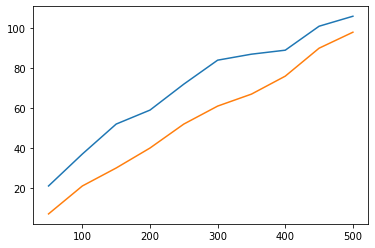

In [134]:
nb_words = [50,100,150,200,250,300,350,400,450,500]
clusters_1 = np.zeros(len(nb_words))
clusters_2 = np.zeros(len(nb_words))
for i,nb in enumerate(nb_words) :
    print(nb)
    A = get_matrix(nb)[0]
    classes_1 = louvain(critere1,A)
    clusters_1[i] = len(classes_1)
    classes_2 = louvain(critere2,A)
    clusters_2[i] = len(classes_2)
    
plt.plot(nb_words,clusters_1)
plt.plot(nb_words,clusters_2)

plt.show()

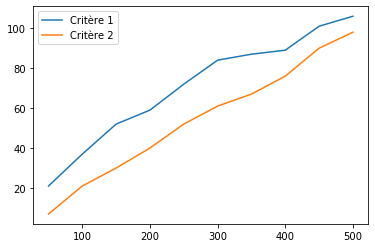

In [136]:
plt.plot(nb_words,clusters_1,label='Critère 1')
plt.plot(nb_words,clusters_2, label="Critère 2")
plt.legend()

## Attrbution phrase cluster

In [74]:
clusters = classes_labels(classes_finales3,100)
def is_in_clusters(word):
    res = False
    index = 0
    for i,classe in enumerate(clusters) :
        for w in classe :
            if word == w :
                res = True
                index = i
                break
    return res,index

def attribute_cluster(row):
    sentences = row['words_lemmatized']
    cs = []
    for sentence in sentences :
        c = []
        for word in sentence :
            
            res,i = is_in_clusters(word)
            if res :
                c.append(i)
            else :
                c.append('None')
        cs.append(c)
    return c

processed_df['clustered'] = processed_df.apply(attribute_cluster,axis=1)

count = 0
for review in processed_df['clustered']:
    for sentence in review :

        if sentence != 'None':
            count += 1
percentage = count/len(processed_df['clustered'])*100

print("Il y a "+ str(percentage) + " % de review attribuées à des clusters")

                
                

Il y a 4 clusters
Il y a 63.236666666666665 % de review attribuées à des clusters


In [75]:
print(processed_df['clustered'].loc[:50])

0                                      [0]
1           [3, None, None, 2, None, None]
2     [3, None, 3, None, None, None, None]
3                                   [None]
4                       [None, None, None]
5                                   [None]
6                                   [None]
7                                      [0]
8                                   [None]
9                                [0, None]
10                                     [0]
11                      [None, None, 2, 2]
12                               [None, 3]
13                               [None, 3]
14                               [0, None]
15                                  [None]
16                                  [None]
17                                      []
18                         [None, None, 2]
19                      [None, 0, None, 0]
20                               [0, 0, 0]
21                      [None, None, None]
22                                     [3]
23         

## Attribution des clusters